![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7031, 9)
(3464, 9)


In [ ]:
y_train.value_counts()

1    4063
0    2968
Name: HighPrice, dtype: int64

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [ ]:
# Celda 1


# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [ ]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=20)
tree

{'gain': 0.2344664960680295,
 'level': 0,
 'n_samples': 7031,
 'sl': {'gain': 0.03387526195829846,
  'level': 1,
  'n_samples': 4352,
  'sl': {'gain': 0.04090195753846798,
   'level': 2,
   'n_samples': 1383,
   'sl': {'gain': 0.0651085063725203,
    'level': 3,
    'n_samples': 183,
    'sl': {'gain': 0.0178444931691685,
     'level': 4,
     'n_samples': 77,
     'sl': {'gain': 0.08172095284394748,
      'level': 5,
      'n_samples': 22,
      'sl': {'gain': 0.1291810841983853,
       'level': 6,
       'n_samples': 17,
       'split': -1,
       'y_pred': 0,
       'y_prob': 0.15789473684210525},
      'split': [2, 1.0],
      'sr': {'gain': 0.21333333333333332,
       'level': 6,
       'n_samples': 5,
       'split': -1,
       'y_pred': 1,
       'y_prob': 0.5714285714285714},
      'y_pred': 0,
      'y_prob': 0.25},
     'split': [1, 35270.28571428571],
     'sr': {'gain': 0.0026446280991735197,
      'level': 5,
      'n_samples': 55,
      'sl': {'gain': 0,
       'level': 6

In [ ]:
y_predict = tree_predict(X_test, tree)

print("Decision Tree Classifier - Manualmente")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")


Decision Tree Classifier - Manualmente
Accuracy: 0.8848152424942263
F1_score: 0.9043394869335891


In [ ]:
## Árbol de decisión con sklearn + calibracion de max_depth

param = {'max_depth': np.arange(1, 30)}


grid_search=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=param,cv=5,n_jobs=-1,verbose=2, scoring='accuracy')
grid_search.fit(X_train.values, y_train.values)

print("Calibracion del max_depth Decision Tree usando GridSearch")
print(f'Best params: {grid_search.best_params_}')
print(f'Best estimator: {grid_search.best_estimator_}')

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Calibracion del max_depth Decision Tree usando GridSearch
Best params: {'max_depth': 6}
Best estimator: DecisionTreeClassifier(max_depth=6)


In [ ]:
clf = DecisionTreeClassifier(max_depth=6, random_state=1)
clf.fit(X_train.values, y_train.values)

y_predict = clf.predict(X_test.values)

print("Decision Tree Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

Decision Tree Classifier
Accuracy: 0.8833718244803695
F1_score: 0.9033955045432808


El acurracy del modelo en el set de test es de 0.883.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2

def get_idx_bootstrap_sample(max_samples, X):
    n_samples = X.shape[0]
    if max_samples is None:
        return np.random.choice(a=n_samples, size=n_samples, replace=True)
    else:
        return np.random.choice(a=n_samples, size=max_samples, replace=True)
    

In [ ]:
n_estimators = 10

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

models = {}
max_samples = None

for i in range(n_estimators):

    #bootstrap
    idx = get_idx_bootstrap_sample(max_samples, X_train)

    #models
    models[i] = DecisionTreeClassifier(max_depth=6, random_state=seeds[i])
    models[i].fit(X_train.iloc[idx], y_train.iloc[idx])

In [ ]:
accuracys = []
f1s = []
for i in range(n_estimators):
    y_predict = models[i].predict(X_test.values)
    acc = accuracy_score(y_test.values, y_predict)
    f1 = f1_score(y_test.values, y_predict)
    accuracys.append(acc)
    f1s.append(f1)
    print(f'Model {i} Accuracy={acc}, F1={f1}')

Model 0 Accuracy=0.8793302540415704, F1=0.898691226369365
Model 1 Accuracy=0.8839491916859122, F1=0.9036433365292427
Model 2 Accuracy=0.875866050808314, F1=0.8945561549779304
Model 3 Accuracy=0.8859699769053118, F1=0.9054797798516392
Model 4 Accuracy=0.8804849884526559, F1=0.9016627078384798
Model 5 Accuracy=0.8816397228637414, F1=0.9005819592628516
Model 6 Accuracy=0.8793302540415704, F1=0.898838334946757
Model 7 Accuracy=0.8680715935334873, F1=0.8902233965889983
Model 8 Accuracy=0.8773094688221709, F1=0.8958588581230091
Model 9 Accuracy=0.8825057736720554, F1=0.9012375636981317


In [ ]:
#predict dataframe
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = models[i].predict(X_test.values)

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print("Ensamble Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_pred)}')
print(f"F1_score: {f1_score(y_test.values, y_pred)}")

Ensamble Classifier
Accuracy: 0.8874133949191686
F1_score: 0.906653901388224


El accuracy del modelo bagging manual con 10 árboles de clasificación es de 0.887, lo que muestra un mejor desempeño que el modelo del punto anterior.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 3

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), max_features=int(np.log2(X_train.shape[1])),n_estimators=10, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

clf.fit(X_train.values, y_train.values)

y_predict = clf.predict(X_test.values)

print("Bagging Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")


Bagging Classifier
Accuracy: 0.8801963048498845
F1_score: 0.9036452286974692


El accuracy del modelo bagging con 10 árboles de clasificación y max_features igual a log(n_features) es de 0.880, lo que muestra un peor desempeño que el bagging manual estimado con el total de features.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 4
clf = RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=100, random_state=1)
clf.fit(X_train.values, y_train.values)

y_predict = clf.predict(X_test.values)

print("RandomForest Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

a1 = accuracy_score(y_test.values, y_predict)

RandomForest Classifier
Accuracy: 0.8429561200923787
F1_score: 0.8660758247168884


El accuracy del modelo Random Forest para clasificación es de 0.84, lo que muestra un peor desempeño que los modelos estimados anteriormente.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

best max_depth= 7


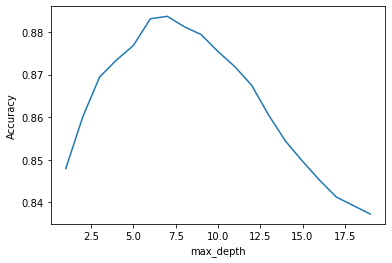

In [ ]:
# Calibracion secuencial

max_depth_range = np.arange(1, 20)

accuracy_scores_max_depth = []

for i in max_depth_range:
    clf = RandomForestClassifier(max_depth=i, random_state=1, n_jobs=-1)
    accuracy_scores_max_depth.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

    
plt.plot(max_depth_range, accuracy_scores_max_depth)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

print(f'best max_depth= {max_depth_range[np.argmax(accuracy_scores_max_depth)]}')

best n_estimators= 81


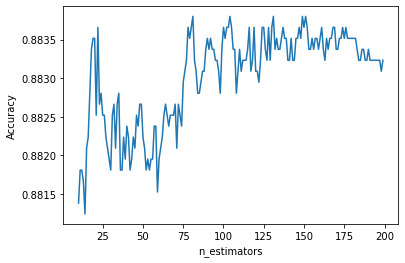

In [ ]:

n_estimators_range = range(10, 200)

accuracy_scores_estimators = []

for i in n_estimators_range:
    clf = RandomForestClassifier(max_depth=7,n_estimators=i, random_state=1, n_jobs=-1)
    accuracy_scores_estimators.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    

plt.plot(n_estimators_range, accuracy_scores_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

print(f'best n_estimators= {n_estimators_range[np.argmax(accuracy_scores_estimators)]}')

best max_features= 3


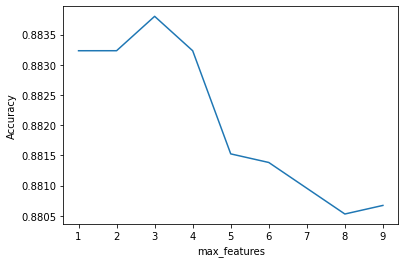

In [ ]:
feature_range = range(1, X_train.shape[1] + 1)

accuracy_scores_features = []

for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=81, max_depth=7, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores_features.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
plt.plot(feature_range, accuracy_scores_features)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

print(f'best max_features= {feature_range[np.argmax(accuracy_scores_features)]}')

In [ ]:
clf = RandomForestClassifier(max_depth=7, max_features=3, n_estimators=81, random_state=1)
clf.fit(X_train.values, y_train.values)

y_predict = clf.predict(X_test.values)

print("RandomForest Classifier - Calibrado")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

a2 = accuracy_score(y_test.values, y_predict)

RandomForest Classifier - Calibrado
Accuracy: 0.8871247113163973
F1_score: 0.9066157153092906


In [ ]:
# calibracion con RandomizedSearchCV
param = {'max_depth': np.arange(1, 40),
        'n_estimators': np.arange(10, 200),
        'max_features': ['sqrt', 2, 3, 4, 5, 6]}

bc_gs = RandomizedSearchCV(RandomForestClassifier(), param, n_iter=100, cv=5, verbose=2, random_state=100,n_jobs=-1, scoring='accuracy')
bc_gs.fit(X_train.values, y_train.values)

print("Calibracion de RandomForest")
print(f'Best estimator: {bc_gs.best_estimator_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Calibracion de RandomForest
Best estimator: RandomForestClassifier(max_depth=6, max_features=3, n_estimators=142)


In [ ]:
y_predict = bc_gs.predict(X_test.values)

print("RandomForest Classifier - Calibrado con RandomizedSearchCV")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

RandomForest Classifier - Calibrado con RandomizedSearchCV
Accuracy: 0.8877020785219399
F1_score: 0.9067816918284208


Al calibrar los parámetros max_features, n_estimators y max_depth se encontraron los siguientes valores óptimos: 

* max_depth: 7. Se observa que el accuracy aumenta hasta una profundidad de 7 y a partir de este valor, el accuracy disminuye con cada aumento en la profundidad. 
* n_estimators: 81. Se observa que el accuracy logra su mayor valor cuando el número de estimadores es igual a 81, a partir de este punto parece que el accuracy logra una relativa estabilidad sin grandes cambios ante aumentos en el número de estimadores.
* max_features: 3. Se observa que el accuracy logra su mayor valor cuando el número de variables es igual a 3, a partir de este punto el accuracy se ve afectado negativamente ante aumentos en el número de variables. Esto muestra que no necesariamente el valor por defecto o todas las variables garantizan el mejor desempeño del modelo.

El accuracy del Random Forest para clasificación con estos parámetros es de 0.888.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 6
from xgboost import XGBClassifier
clf = XGBClassifier(eval_metric='logloss', random_state=1)
clf.fit(X_train.values, y_train.values)

y_predict = clf.predict(X_test.values)

print("XGBoost classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

a3 = accuracy_score(y_test.values, y_predict)

XGBoost classifier
Accuracy: 0.8877020785219399
F1_score: 0.9070045421945971


El modelo XGBoost tiene un accuracy de 0.887, lo que muestra un desempeño cercano al modelo estimado por Random Forest con parámetros calibrados.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

best eta= 0.041666666666666664


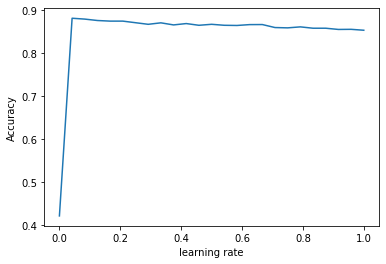

In [ ]:
# Calibracion secuencial

eta_range = np.linspace(0, 1, 25)

accuracy_scores = []

for i in eta_range:
    clf = XGBClassifier(eta=i, eval_metric='logloss')
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    

plt.plot(eta_range, accuracy_scores)
plt.xlabel('learning rate')
plt.ylabel('Accuracy')

print(f'best eta= {eta_range[np.argmax(accuracy_scores)]}')

best colsample_bytree= 0.4


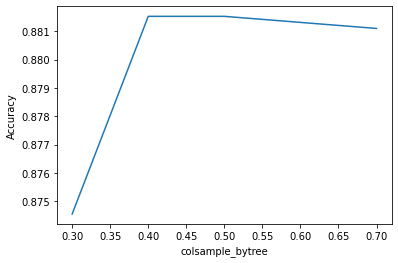

In [ ]:
colsample_bytree_range = [ 0.3, 0.4, 0.5 , 0.7 ]

accuracy_scores = []

for i in colsample_bytree_range:
    clf = XGBClassifier(eta=0.041666666666666664, colsample_bytree=i, eval_metric='logloss')
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    

plt.plot(colsample_bytree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

print(f'best colsample_bytree= {colsample_bytree_range[np.argmax(accuracy_scores)]}')

best gamma= 1.507537688442211


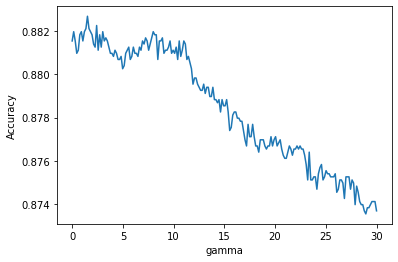

In [ ]:
gamma_range =np.linspace(0, 30, 200)

accuracy_scores = []

for i in gamma_range:
    clf = XGBClassifier(eta=0.041666666666666664, colsample_bytree=0.4, gamma=i, eval_metric='logloss')
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    

plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

print(f'best gamma= {gamma_range[np.argmax(accuracy_scores)]}')

In [ ]:
xg_clas = XGBClassifier(eta=0.041666666666666664,colsample_bytree=0.4, gamma=1.507537688442211, eval_metric='logloss', random_state=1)

xg_clas.fit(X_train.values, y_train.values)

y_predict = xg_clas.predict(X_test.values)

print("XGBoost classifier - calibrado")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

a4 = accuracy_score(y_test.values, y_predict)

XGBoost classifier - calibrado
Accuracy: 0.8877020785219399
F1_score: 0.9071820567883561


In [ ]:
# calibracion con RandomizedSearchCV

from sklearn.model_selection import KFold

params = {
    'min_child_weight': [ 1, 3, 5, 7 ],
    'gamma': np.linspace(0, 30, 200),
    'eta': np.linspace(0, 1, 25),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
    'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15]
}

xg_class = XGBClassifier(eval_metric='logloss')

random_search = RandomizedSearchCV(xg_class, param_distributions=params, n_iter=300, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=1001 )

random_search.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(eval_metric='logloss'),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'eta': array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.8333333...
       27.13567839, 27.28643216, 27.43718593, 27.5879397 , 27.73869347,
       27.88944724, 28.04020101, 28.19095477, 28.34170854, 28.49246231,
       28.64321608, 28.79396985, 28.94472362, 29.09547739, 29.24623116,
       29.39698492, 29.54773869, 29.69849246, 29.84924623, 30.        ]),
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                        

In [ ]:
print(random_search.best_estimator_)
print(random_search.best_params_)

XGBClassifier(colsample_bytree=0.4, eta=0.3333333333333333,
              eval_metric='logloss', gamma=6.331658291457286, max_depth=15,
              min_child_weight=7, subsample=0.6)
{'subsample': 0.6, 'min_child_weight': 7, 'max_depth': 15, 'gamma': 6.331658291457286, 'eta': 0.3333333333333333, 'colsample_bytree': 0.4}


In [ ]:
xg_clas = XGBClassifier(colsample_bytree=0.4, eta=0.3333333333333333,
              eval_metric='logloss', gamma=6.331658291457286,subsample=0.6, min_child_weight=7, max_depth=15, 
              random_state=101)

xg_clas.fit(X_train.values, y_train.values)

y_predict = xg_clas.predict(X_test.values)

print("XGBoost classifier - calibrado por RandomizedSearchCV")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

a5 = accuracy_score(y_test.values, y_predict)

XGBoost classifier - calibrado por RandomizedSearchCV
Accuracy: 0.8891454965357968
F1_score: 0.908133971291866


Al calibrar los parámetros learning_rate, gamma y colsample_bytree se encontraron los siguientes valores óptimos:

* learning_rate: 0.042. Se observa que el accuracy aumenta hasta una tasa de aprendizaje de 0.042 y a partir de este valor parece que el accuracy logra estabilidad sin grandes cambios ante aumentos en la tasa de aprendizaje.
* gamma: 1.507. Se observa que el accuracy logra su mayor valor cuando gamma (reducción de pérdida mínima necesaria para realizar una partición adicional en un nodo de hoja del árbol) es igual a 1.507, a partir de este punto el accuracy se ve afectado negativamente ante aumentos en gamma.
* colsample_bytree: 0.4. Se observa que el accuracy logra su mayor valor cuando colsample_bytree (relación de submuestra de las columnas al construir cada árbol) es igual a 0.4 y a partir de este valor parece que el accuracy logra estabilidad sin grandes cambios ante aumentos en gamma.

El accuracy del XGBosst para clasificación con estos parámetros es de 0.886. Adicionalmente, al calibrar el modelo a través de cross-validation aleatorio se logra estimar un modelo con accuracy de 0.889

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
print("El accuracy del Random Forest fue:", a1)
print("El accuracy del Random Forest calibrado fue:", a2)
print("El accuracy del XGBoost fue:", a3)
print("El accuracy del XGBoost calibrado fue:", a5)

El accuracy del Random Forest fue: 0.8429561200923787
El accuracy del Random Forest calibrado fue: 0.8871247113163973
El accuracy del XGBoost fue: 0.8877020785219399
El accuracy del XGBoost calibrado fue: 0.8891454965357968


El modelo XGBoost tiene el mejor desempeño predictivo que el modelo Random Forest, debido a la construcción secuencial de los árboles y la combinación de resultados durante el entrenamiento del modelo. La desventaja del Random Forest es que combina el resultado hasta el final.